## Assignment: Image recognition
- Alumno 1:
- Alumno 2:
- Alumno 3:

The goals of the assignment are:
* Develop proficiency in using Tensorflow/Keras for training Neural Nets (NNs).
* Put into practice the acquired knowledge to optimize the parameters and architecture of a feedforward Neural Net (ffNN), in the context of an image recognition problem.
* Put into practice NNs specially conceived for analysing images. Design and optimize the parameters of a Convolutional Neural Net (CNN) to deal with previous task.
* Train popular architectures from scratch (e.g., GoogLeNet, VGG, ResNet, ...), and compare the results with the ones provided by their pre-trained versions using transfer learning.

Follow the link below to download the classification data set  “xview_recognition”: [https://drive.upm.es/s/4oNHlRFEd71HXp4](https://drive.upm.es/s/4oNHlRFEd71HXp4)

In [20]:
import tensorflow as tf

# Check for available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            print(gpu)
            tf.config.experimental.set_memory_growth(gpu, True)
        
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


In [21]:
import uuid
import numpy as np

class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category= -1
        self.score = -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)

In [22]:
categories = {0: 'Cargo plane', 1: 'Helicopter', 2: 'Small car', 3: 'Bus', 4: 'Truck', 5: 'Motorboat', 6: 'Fishing vessel', 7: 'Dump truck', 8: 'Excavator', 9: 'Building', 10: 'Storage tank', 11: 'Shipping container'}

In [23]:
import warnings
import rasterio

def load_geoimage(filename):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    src_raster = rasterio.open(filename, 'r')
    # RasterIO to OpenCV (see inconsistencies between libjpeg and libjpeg-turbo)
    input_type = src_raster.profile['dtype']
    input_channels = src_raster.count
    img = np.zeros((src_raster.height, src_raster.width, src_raster.count), dtype=input_type)
    for band in range(input_channels):
        img[:, :, band] = src_raster.read(band+1)
    return img

def generator_images(objs, batch_size, do_shuffle=False):
    while True:
        if do_shuffle:
            np.random.shuffle(objs)
        groups = [objs[i:i+batch_size] for i in range(0, len(objs), batch_size)]
        for group in groups:
            images, labels = [], []
            for (filename, obj) in group:
                # Load image
                images.append(load_geoimage(filename))
                probabilities = np.zeros(len(categories))
                probabilities[list(categories.values()).index(obj.category)] = 1
                labels.append(probabilities)
            images = np.array(images).astype(np.float32)
            labels = np.array(labels).astype(np.float32)
            yield images, labels

In [24]:
import matplotlib.pyplot as plt

def draw_confusion_matrix(cm, categories):
    # Draw confusion matrix
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=list(categories.values()), yticklabels=list(categories.values()), ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(20-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show(fig)

#### Training
Design and train a ffNN to deal with the “xview_recognition” classification task.

In [25]:
import json

# Load database
json_file = '/kaggle/input/dataset/xview_ann_train.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [26]:
counts = dict.fromkeys(categories.values(), 0)
anns = []
for json_img, json_ann in zip(json_data['images'].values(), json_data['annotations'].values()):
    image = GenericImage(json_img['filename'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = json_ann['category_id']
    # Resampling strategy to reduce training time
    counts[obj.category] += 1
    image.add_object(obj)
    anns.append(image)
print(counts)

{'Cargo plane': 635, 'Helicopter': 70, 'Small car': 4290, 'Bus': 2155, 'Truck': 2746, 'Motorboat': 1069, 'Fishing vessel': 706, 'Dump truck': 1236, 'Excavator': 789, 'Building': 4689, 'Storage tank': 1469, 'Shipping container': 1523}


In [27]:
# Load architecture
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 64

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    validation_split=0.1
)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/dataset/xview_train',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

valid_generator = train_datagen.flow_from_directory(
    '/kaggle/input/dataset/xview_train',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

model = Sequential()
model.add(Conv2D(32, kernel_size=4, strides=1, activation='relu', input_shape=(224, 224, 3)))
model.add(Conv2D(64, kernel_size=4, strides=1, activation='relu'))
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(12, activation='softmax'))

model.summary()

Found 19246 images belonging to 12 classes.
Found 2131 images belonging to 12 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 221, 221, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 218, 218, 64)   │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3041536)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3041536)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │    36,498,444 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,532,844 (139.36 MB)

 Trainable params: 36,532,844 (139.36 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
from tensorflow.keras.optimizers import Nadam

opt = Nadam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8, clipnorm=1.0, clipvalue=0.5)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
from tensorflow.keras.callbacks import TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Callbacks
model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau('val_accuracy', factor=0.1, patience=5, verbose=1)
early_stop = EarlyStopping('val_loss', patience=20, verbose=1)
terminate = TerminateOnNaN()
callbacks = [model_checkpoint, reduce_lr, early_stop, terminate]

Training model
Epoch 1/40


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 986ms/step - accuracy: 0.3473 - loss: 4.1652
Epoch 1: val_accuracy improved from -inf to 0.46504, saving model to model.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 344s 1s/step - accuracy: 0.3476 - loss: 4.1587 - val_accuracy: 0.4650 - val_loss: 1.5768 - learning_rate: 0.0010
Epoch 2/40
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 974ms/step - accuracy: 0.4993 - loss: 1.4985
Epoch 2: val_accuracy improved from 0.46504 to 0.52792, saving model to model.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 335s 1s/step - accuracy: 0.4993 - loss: 1.4984 - val_accuracy: 0.5279 - val_loss: 1.4226 - learning_rate: 0.0010
Epoch 3/40
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 965ms/step - accuracy: 0.5341 - loss: 1.3823
Epoch 3: val_accuracy improved from 0.52792 to 0.54575, saving model to model.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 332s 1s/step - accuracy: 0.5341 - loss: 1.3823 - val_accuracy: 0.5458 - val_loss: 1.3507 - learning_rate: 0.0010
Epoch 4/40
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 980ms/step - accuracy: 0.5608

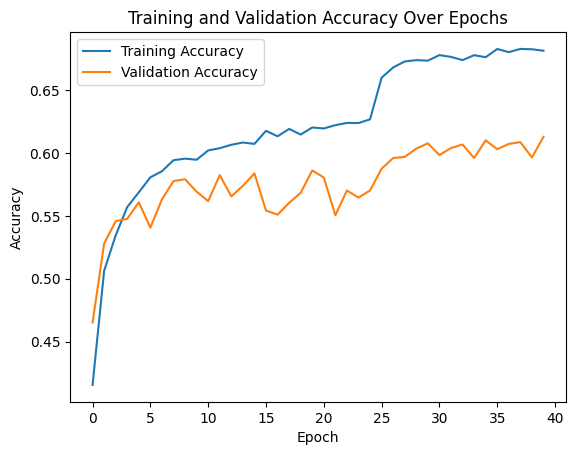

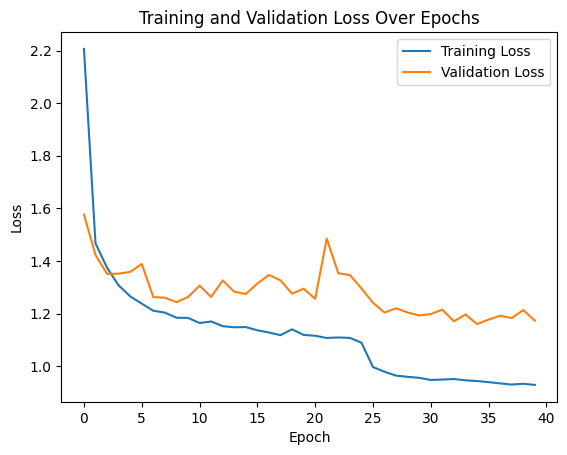

Best validation model: epoch 40  - val_accuracy 0.6128578186035156


In [30]:
import math

print('Training model')
epochs = 40

h = model.fit(train_generator, validation_data=valid_generator, epochs=epochs, callbacks=callbacks, verbose=1)

# Plot training and validation accuracy
plt.plot(h.history['accuracy'], label='Training Accuracy')
plt.plot(h.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()
# Plot training and validation loss
plt.plot(h.history['loss'], label='Training Loss')
plt.plot(h.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Best validation model
best_idx = int(np.argmax(h.history['val_accuracy']))
best_value = np.max(h.history['val_accuracy'])
print('Best validation model: epoch ' + str(best_idx+1), ' - val_accuracy ' + str(best_value))

#### Testing
Try to improve the results provided in the Moodle competition wiki.

In [31]:
import json

# Load database
json_file = '/kaggle/input/dataset/xview_ann_test.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [32]:
import numpy as np

anns = []
for json_img, json_ann in zip(json_data['images'].values(), json_data['annotations'].values()):
    image = GenericImage(json_img['filename'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = json_ann['category_id']
    image.add_object(obj)
    anns.append(image)

In [ ]:
# model.load_weights('model.hdf5', by_name=True)
y_true, y_pred = [], []
for ann in anns:
    # Load image
    image = load_geoimage('/kaggle/input/dataset/' + ann.filename)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        y_true.append(obj_pred.category)
        y_pred.append(pred_category)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━

/tmp/ipykernel_34/2386513741.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))


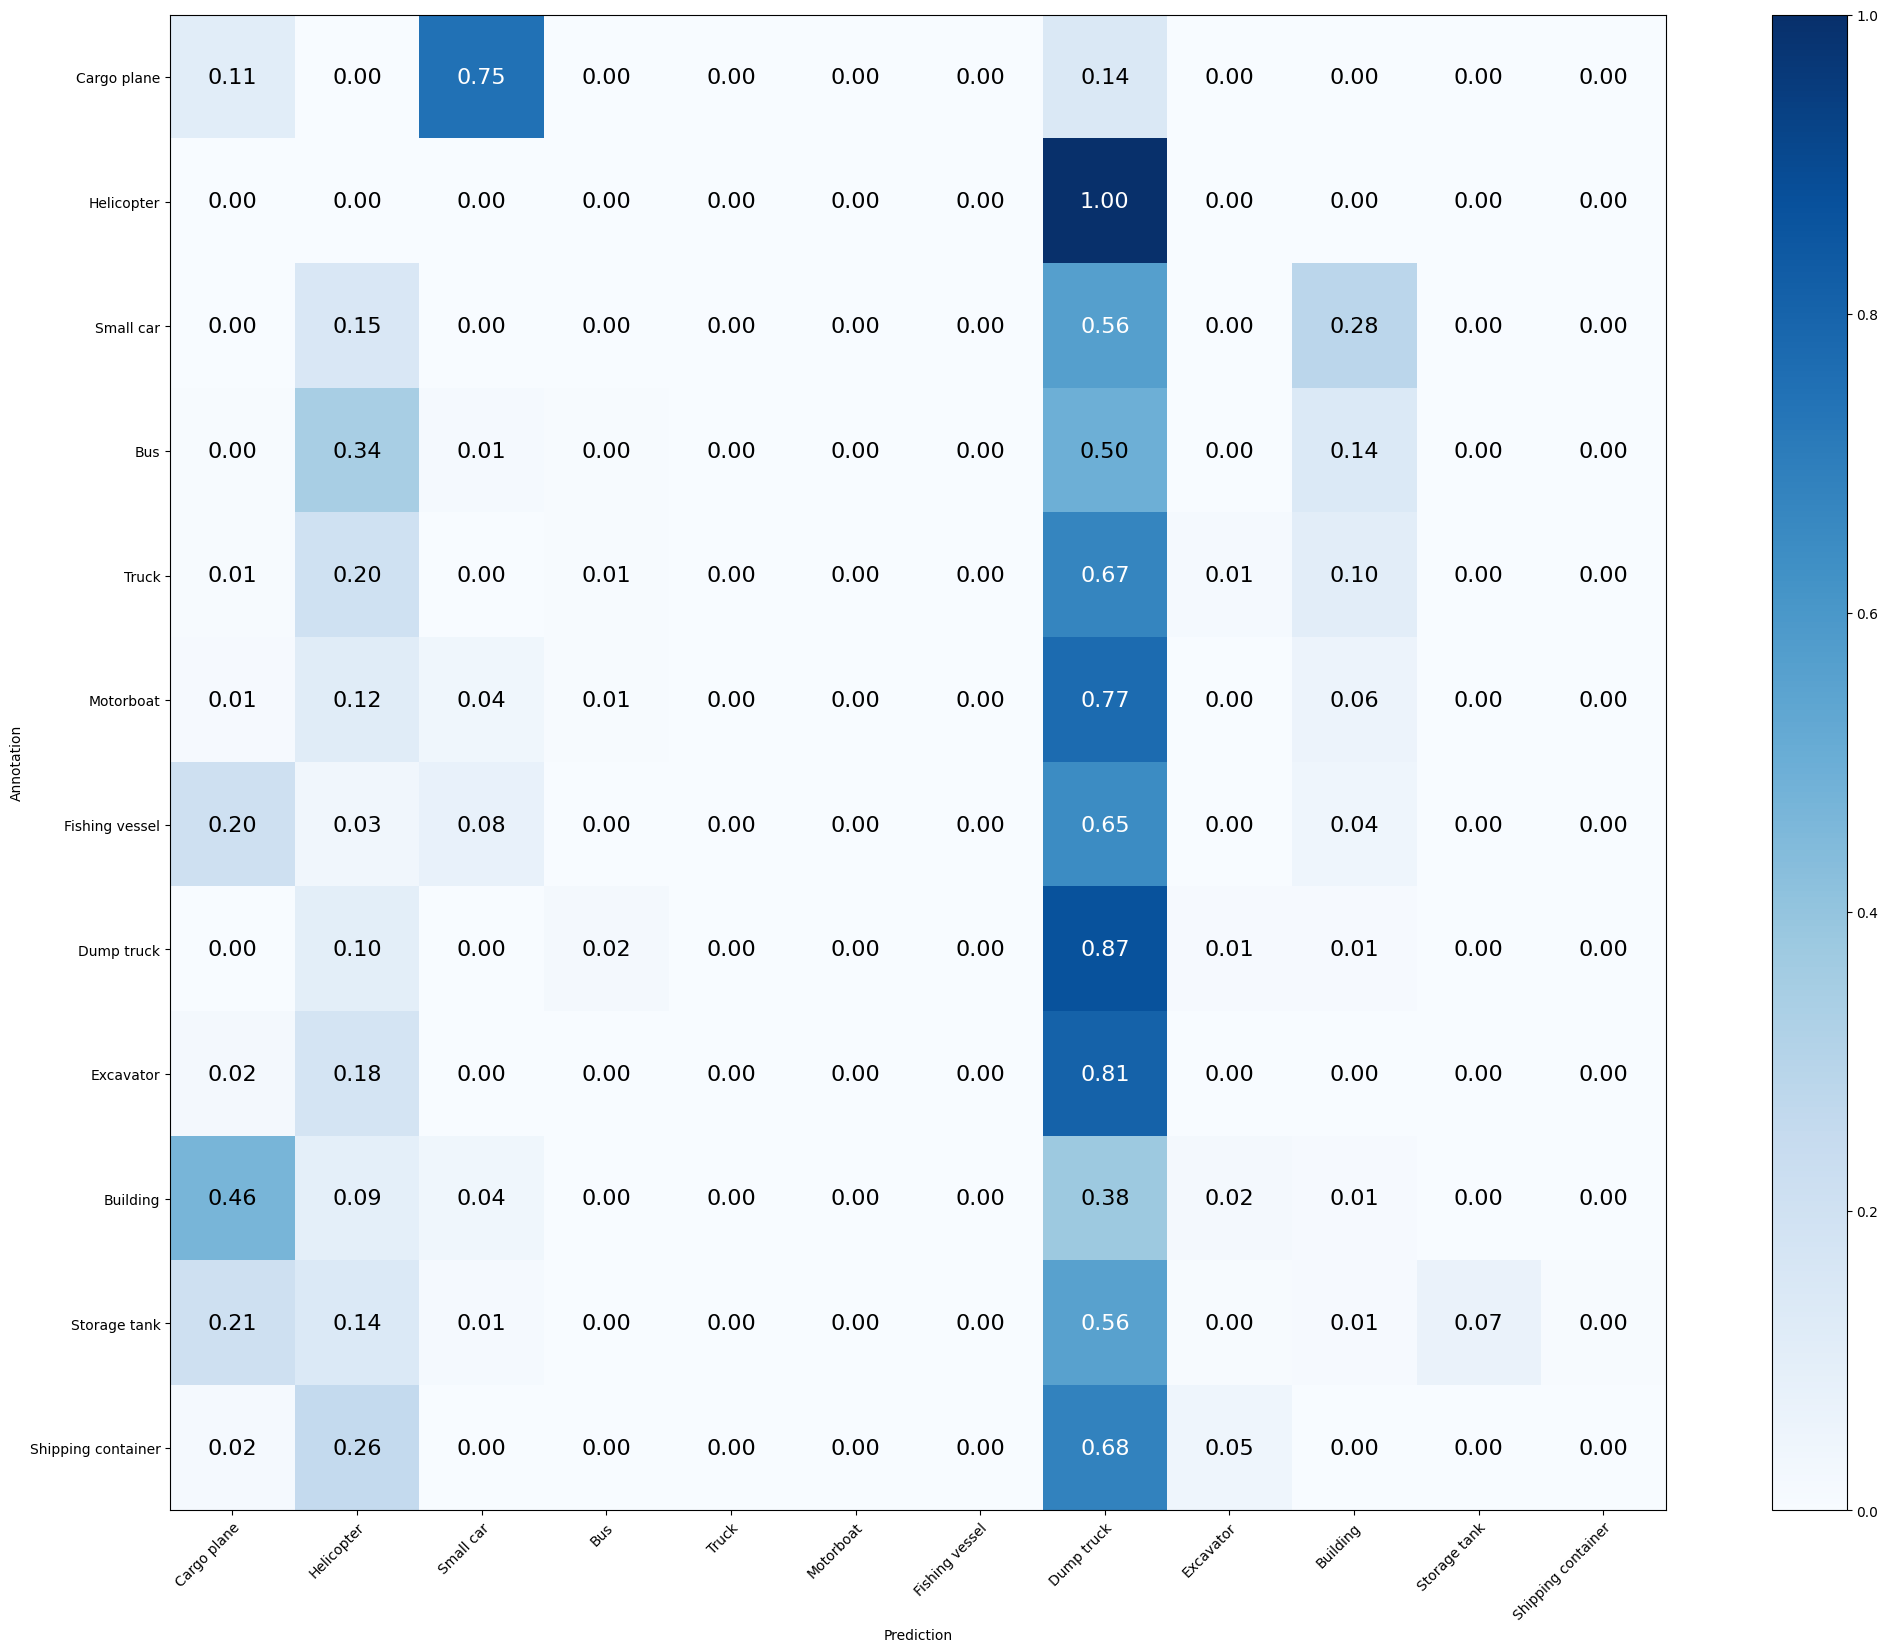

In [36]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(categories.values()))
draw_confusion_matrix(cm, categories)

In [37]:
import numpy as np

# Compute the accuracy
correct_samples_class = np.diag(cm).astype(float)
total_samples_class = np.sum(cm, axis=1).astype(float)
total_predicts_class = np.sum(cm, axis=0).astype(float)
print('Mean Accuracy: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
print('Mean Recall: %.3f%%' % (acc.mean() * 100))
acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
print('Mean Precision: %.3f%%' % (acc.mean() * 100))
for idx in range(len(categories)):
    # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
    # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
    tp = cm[idx, idx]
    fp = sum(cm[:, idx]) - tp
    fn = sum(cm[idx, :]) - tp
    tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
    # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
    recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
    # Precision: proportion of predicted positive cases that were truly real positives.
    precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
    # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
    specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
    # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
    # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
    f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
    print('> %s: Recall: %.3f%% Precision: %.3f%% Specificity: %.3f%% Dice: %.3f%%' % (list(categories.values())[idx], recall*100, precision*100, specificity*100, f1_score*100))

Mean Accuracy: 5.237%
Mean Recall: 8.821%
Mean Precision: 10.088%
> Cargo plane: Recall: 10.843% Precision: 2.639% Specificity: 86.991% Dice: 4.245%
> Helicopter: Recall: 0.000% Precision: 0.000% Specificity: 85.270% Dice: 0.000%
> Small car: Recall: 0.205% Precision: 0.893% Specificity: 94.832% Dice: 0.334%
> Bus: Recall: 0.413% Precision: 14.286% Specificity: 99.749% Dice: 0.803%
> Truck: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Motorboat: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Fishing vessel: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Dump truck: Recall: 86.885% Precision: 7.015% Specificity: 44.091% Dice: 12.982%
> Excavator: Recall: 0.000% Precision: 0.000% Specificity: 99.263% Dice: 0.000%
> Building: Recall: 0.923% Precision: 2.101% Specificity: 88.868% Dice: 1.282%
> Storage tank: Recall: 6.584% Precision: 94.118% Specificity: 99.958% Dice: 12.308%
> Shipping container: Recall: 0.000% Precisi

#### Report

You must prepare a report (PDF) describing:
* The problems and data sets (briefly).
* The process that you have followed to reach your solution for the “xview_recognition” benchmark, including your intermediate results. You must discuss and compare these results properly.
* Final network architectures, including optimization algorithms, regularization methods (dropout, data augmentation, etc.), number of layers/parameters, and performance obtained with your model on the train/valid/test data sets, including the plots of the evolution of losses and accuracy.
* It would also be very valuable your feedback on the use of “Cesvima” or “Google Colab" services.

In the submission via Moodle, attach your Python (.py) or Jupyter Notebook (.ipynb) source file, including in the report all results of computations attached to the code that generated them.

The assignment must be done in groups of 3 students.